# Propensity to Lapse Model building Exercise <br/>


- In this Propensity to Lapse Model building project, the aim is to develop a robust predictive model using Python to identify customers at risk of churn within a loyalty program using raw customer transaction data. This data encompasses various customer interactions, such as earning and redeeming loyalty points from affiliated partners like Tesco and Apple.

- The objective is to analyze and predict customer churn, defined as a lapse in activity for a consecutive 12-month period. Customers who do not engage in collecting or redeeming points within this timeframe are categorized as "lapsed". The provided dataset, after thorough data preprocessing and feature engineering, will serve as the foundation for our model. The key variable of interest, labeled as "State", indicates whether a customer is currently active (0) or lapsed (1).

<br/>

---

> Mesolora Stamatoula Gerasimoula, Student ID: f2822308 <br />
> MSc Business Analytics  <br />
> Course: Analytics Practicum II <br />
> Athens University of Economics and Business <br />

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, f1_score, recall_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
import shap
shap.initjs()
%matplotlib inline

## The given dataset consists of 5000 observations (customers) having the below fields (characteristics): <br/>
* State: Lapsed status of the customer (Active=0, Lapsed=1). This is your target variable.
* Sum_collect: Number of times a customer collected loyalty points.
* Sum_redeem: Number of times a customer redeemed loyalty points.
* Sum_collect_points: Total points collected by the customer.
* Sum_redeem_points: Total points redeemed by the customer.
* Years_in_the_program: Number of years since the customer's registration to the loyalty program.
* Months_since_last_transaction: Number of months passed since the customer's last activity (either collection or redemption).

In [2]:
CustomerChurn_TrData = pd.read_csv('CustomerChurnTrainingData.csv')
ScoreData_Sink = pd.read_csv('ScoreDataSink.csv')
ScoreData_Source = pd.read_csv('ScoreDataSource.csv')

In [3]:
CustomerChurn_TrData.head(5)

,state,sum_collect,sum_redeem,sum_collect_points,sum_redeem_points,years_in_the_program,months_since_last_transaction
0,0,13,0,1269,0.0,19,1
1,1,6,0,2890,0.0,10,10
2,1,2,0,422,0.0,7,9
3,0,7,1,2690,14500.0,16,1
4,1,7,0,211,0.0,2,3


### 1. Descriptive Statistics

In [4]:
print("Basic Statistics:")
CustomerChurn_TrData.describe()

Basic Statistics:


,state,sum_collect,sum_redeem,sum_collect_points,sum_redeem_points,years_in_the_program,months_since_last_transaction
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.00000,5000.00000
mean,0.499200,9.133600,0.166200,6235.350000,2827.35420,9.11940,3.82760
std,0.500049,8.991236,0.622459,16739.259116,14742.02891,6.73595,3.23765
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,1.00000
25%,0.000000,4.000000,0.000000,297.750000,0.00000,5.00000,1.00000
50%,0.000000,6.000000,0.000000,1220.000000,0.00000,6.00000,3.00000
75%,1.000000,13.000000,0.000000,4662.750000,0.00000,13.00000,6.00000
max,1.000000,205.000000,10.000000,304174.000000,401800.00000,27.00000,12.00000


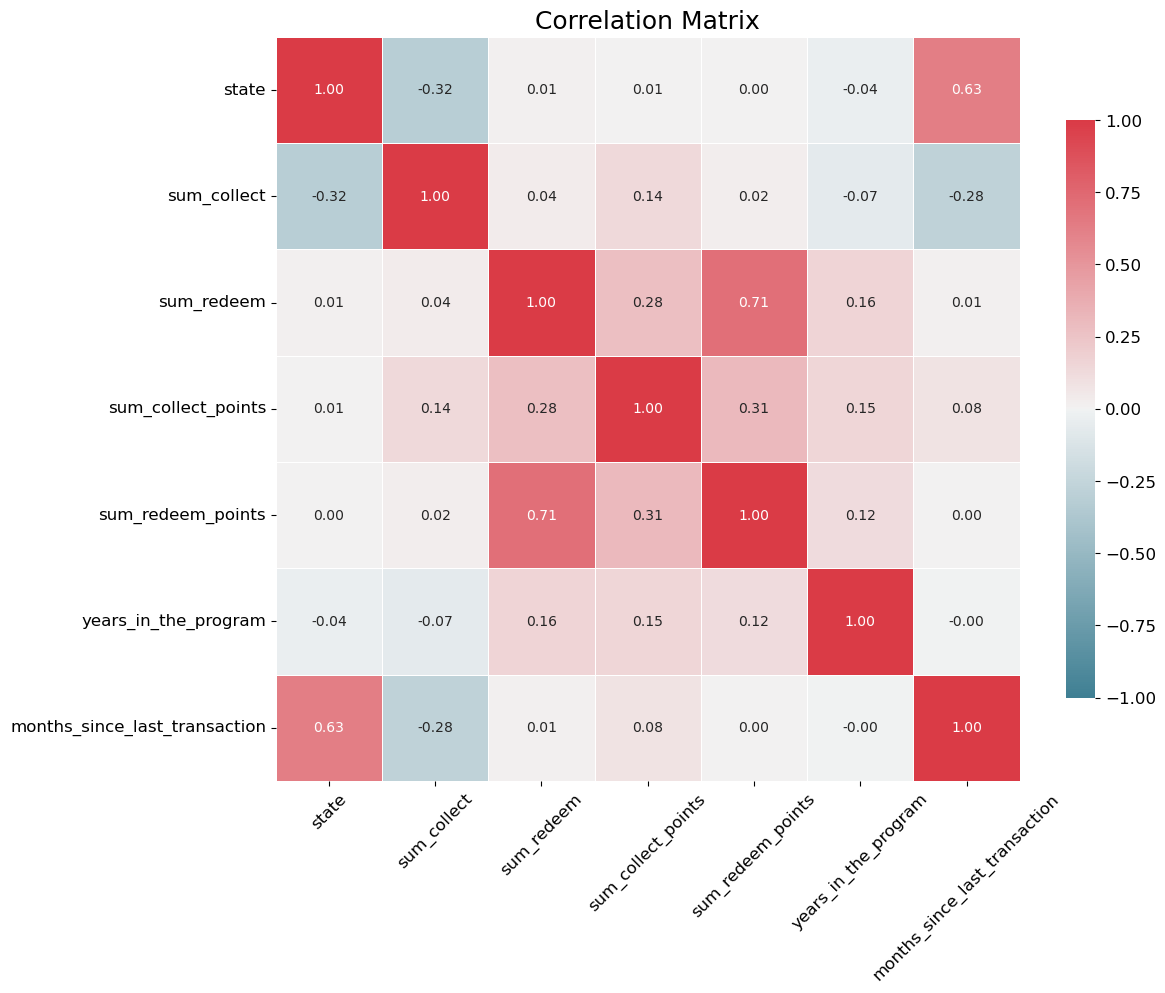

In [5]:
corr_matrix = CustomerChurn_TrData.corr()

plt.figure(figsize=(12, 10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr_matrix, annot = True, cmap = cmap, center = 0,
            square = True, linewidths = 0.5, cbar_kws = {"shrink": 0.75}, fmt = ".2f",
            annot_kws = {"size": 10}, vmin = -1, vmax = 1)

plt.title('Correlation Matrix', fontsize = 18)
plt.xticks(fontsize = 12, rotation = 45)
plt.yticks(fontsize = 12, rotation = 0)

cbar = plt.gcf().axes[-1]
cbar.tick_params(labelsize = 12)

plt.savefig('correlation_matrix.png', bbox_inches = 'tight', dpi = 300)
plt.show()

The below histogram visualizes the distribution of lapsed versus active customers within the initial dataset. The purpose of this visualization is to provide a clear understanding of the class balance in the dataset, which is crucial for developing a reliable predictive model.

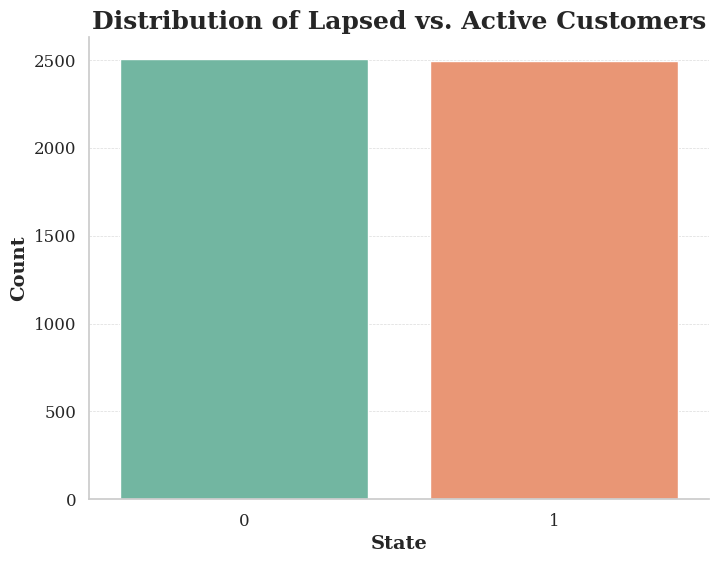

In [6]:
sns.set(style = "whitegrid", palette = "muted")

plt.figure(figsize = (8, 6)) 

ax = sns.countplot(x = 'state', data = CustomerChurn_TrData, palette = 'Set2')

plt.title('Distribution of Lapsed vs. Active Customers', fontsize = 18, weight = 'bold', family = 'serif')
plt.xlabel('State', fontsize = 14, weight = 'bold', family = 'serif')
plt.ylabel('Count', fontsize = 14, weight = 'bold', family = 'serif')

plt.xticks(fontsize = 12, family = 'serif')
plt.yticks(fontsize = 12, family = 'serif')
ax.yaxis.grid(True, linestyle = '--', linewidth = 0.5, alpha = 0.7)
sns.despine()

plt.savefig('distribution_of_state.png', bbox_inches = 'tight', dpi = 300)
plt.show()

In [7]:
X = CustomerChurn_TrData[['sum_collect', 'sum_redeem', 'sum_collect_points', 'sum_redeem_points',
                    'years_in_the_program', 'months_since_last_transaction']]
Y = CustomerChurn_TrData['state']

C:\Users\fani_\AppData\Local\Temp\ipykernel_11500\217612806.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 3, i)


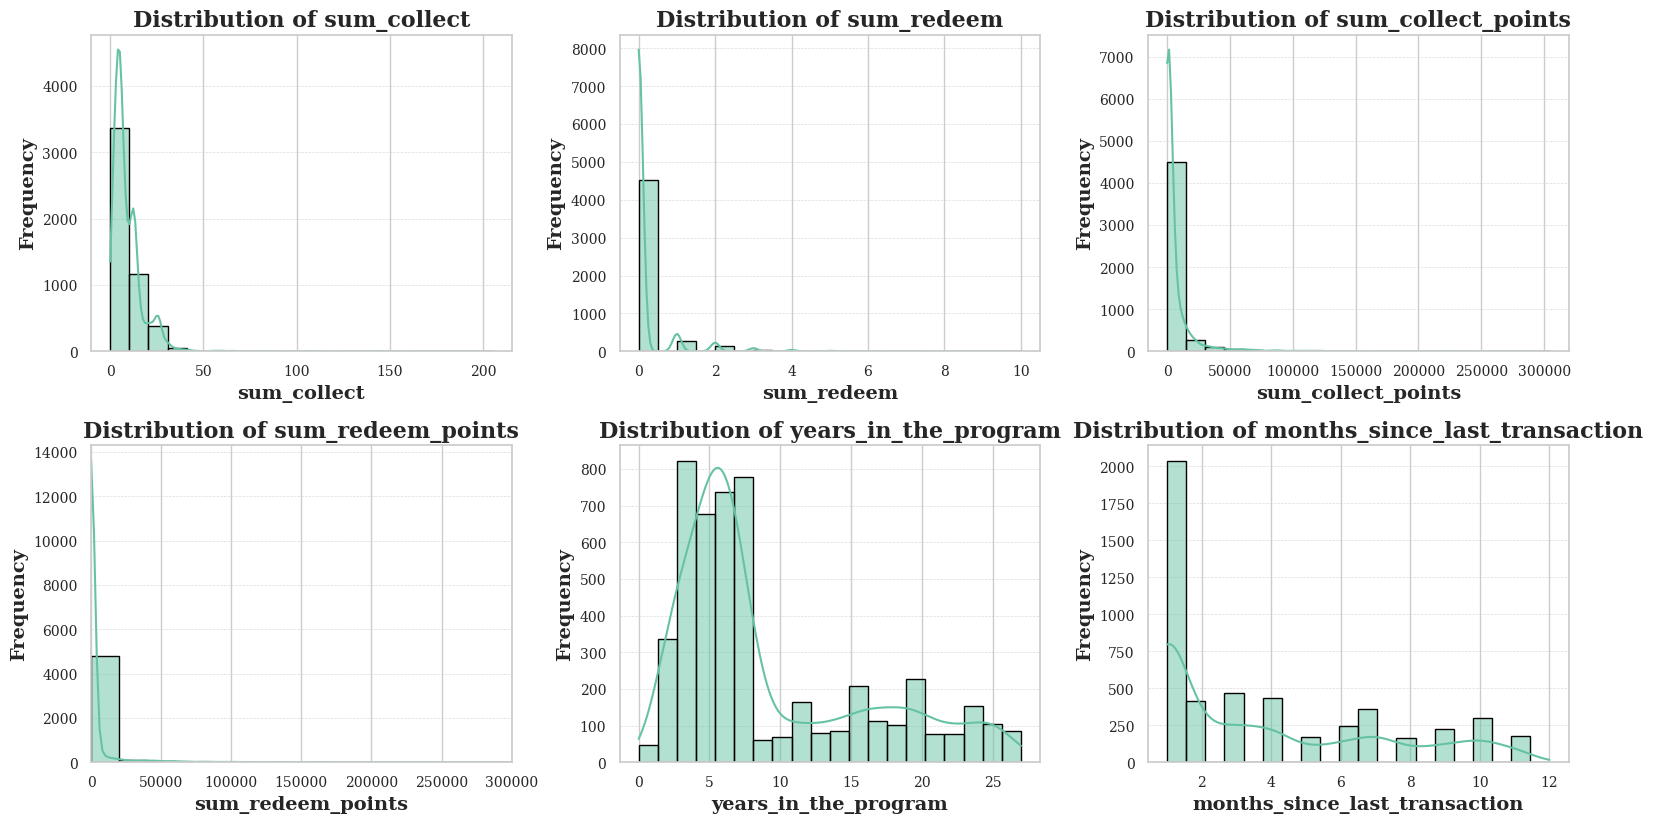

In [8]:
sns.set(style = "whitegrid", palette = "muted")

plt.figure(figsize = (16, 12))

ax = sns.countplot(data = CustomerChurn_TrData, palette = 'Set2')

for i, feature in enumerate(X, 1):
    plt.subplot(3, 3, i)
    sns.histplot(CustomerChurn_TrData[feature], bins = 20, kde = True, color = '#66c2a5', edgecolor = 'black')

    plt.title(f'Distribution of {feature}', fontsize = 16, weight = 'bold', family = 'serif')
    plt.xlabel(feature, fontsize = 14, weight = 'bold', family = 'serif')
    plt.ylabel('Frequency', fontsize = 14, weight = 'bold', family = 'serif')

    if feature == 'sum_redeem_points':
        plt.xlim(0, 300000) 
    
    plt.xticks(fontsize = 10, family = 'serif')
    plt.yticks(fontsize = 10, family = 'serif')

    plt.grid(axis = 'y', linestyle = '--', mfc = 'red', linewidth = 0.5, alpha = 0.7, )

plt.tight_layout()
plt.savefig('distribution_of_numeric_features.png', bbox_inches = 'tight', dpi = 300)
plt.show()

### 2. Predictive Analytics <br/>

- Logistic Regression: A statistical model that uses a logistic function to model the probability of a binary outcome. It is effective for capturing the linear relationship between the features and the log-odds of the target variable, allowing for straightforward interpretability and feature importance analysis. 
- Decision Tree Classifier: A non-parametric model that splits the data into subsets based on feature values, forming a tree-like structure. It finds the optimal splits to classify the data by recursively partitioning it, which makes it powerful for capturing complex interactions and non-linear relationships between features.


For the variable selection of the Logistic Regression model, we execute a stepwise selection method. The selected variables for the Logistic Regression model are the following: <br/>

- months_since_last_transaction
- sum_collect
- years_in_the_program

In [9]:
def stepwise_selection(X, y,
                       initial_list = [],
                       threshold_in = 0.01,
                       threshold_out = 0.05,
                       verbose = True):
    included = list(initial_list)
    while True:
        changed = False
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included + [new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed = True
            if verbose:
                print(f'Add  {best_feature} with p-value {best_pval}')
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max()
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print(f'Drop {worst_feature} with p-value {worst_pval}')
        if not changed:
            break
    return included

selected_variables = stepwise_selection(X, Y)

print('Selected variables:', selected_variables)

Add  months_since_last_transaction with p-value 0.0
Add  sum_collect with p-value 9.118655640051722e-43
Add  years_in_the_program with p-value 3.708434920498814e-05
Selected variables: ['months_since_last_transaction', 'sum_collect', 'years_in_the_program']


The performance of the Logistic Regression model with the selected variables is the following:

- Accuracy: 0.794
- F1 Score: 0.7751091703056768
- Recall: 0.7114228456913828
- ROC AUC Score: 0.7938351753407015

In [10]:
X = CustomerChurn_TrData[['sum_redeem_points', 'years_in_the_program', 'months_since_last_transaction']]
y = CustomerChurn_TrData['state']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

logreg = LogisticRegression(max_iter = 1000) 
logreg.fit(X_train, y_train)

y_pred_logreg = logreg.predict(X_test)

print("Logistic Regression Performance:")
print(classification_report(y_test, y_pred_logreg))
print("Accuracy:", accuracy_score(y_test, y_pred_logreg))
print("F1 Score:", f1_score(y_test, y_pred_logreg))
print("Recall:", recall_score(y_test, y_pred_logreg))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_logreg))

Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.75      0.88      0.81       501
           1       0.85      0.71      0.78       499

    accuracy                           0.79      1000
   macro avg       0.80      0.79      0.79      1000
weighted avg       0.80      0.79      0.79      1000

Accuracy: 0.794
F1 Score: 0.7751091703056768
Recall: 0.7114228456913828
ROC AUC Score: 0.7938351753407015


This below histogram visualizes the distribution of lapsed versus active customers within the training dataset. We see that the distribution of the class balance has remained the same as in the initial dataset.

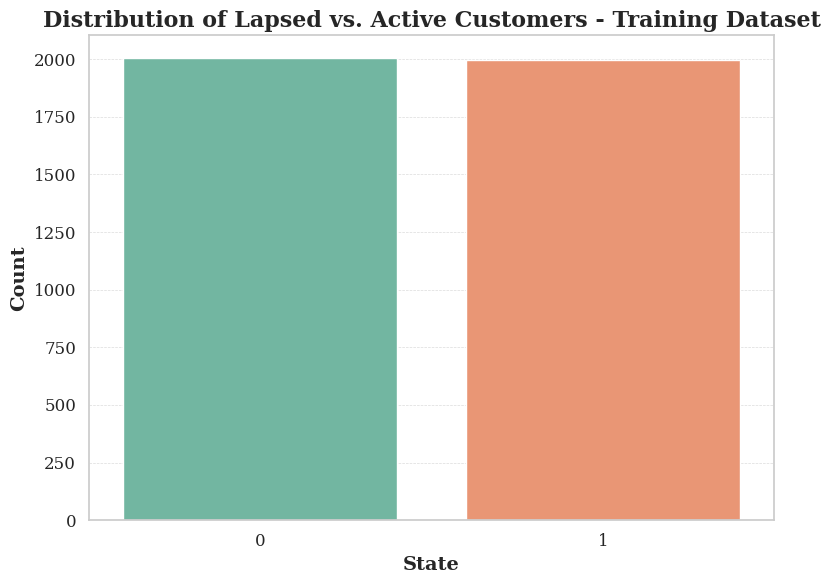

In [11]:
y_train_df = pd.DataFrame(y_train, columns = ['state'])

sns.set(style = "whitegrid", palette = "Set2")
plt.figure(figsize = (8, 6))

ax = sns.countplot(x = 'state', data = y_train_df, palette = "Set2")

plt.title('Distribution of Lapsed vs. Active Customers - Training Dataset', fontsize = 16, weight = 'bold', family = 'serif')
plt.xlabel('State', fontsize = 14, weight = 'bold', family = 'serif')
plt.ylabel('Count', fontsize=14, weight = 'bold', family = 'serif')

plt.xticks(fontsize = 12, family = 'serif')
plt.yticks(fontsize = 12, family = 'serif')
plt.grid(axis = 'y', linestyle = '--', linewidth = 0.5, alpha = 0.7)

plt.tight_layout()
plt.savefig('distribution_of_lapsed_vs_active_customers.png', bbox_inches = 'tight', dpi = 300)
plt.show()

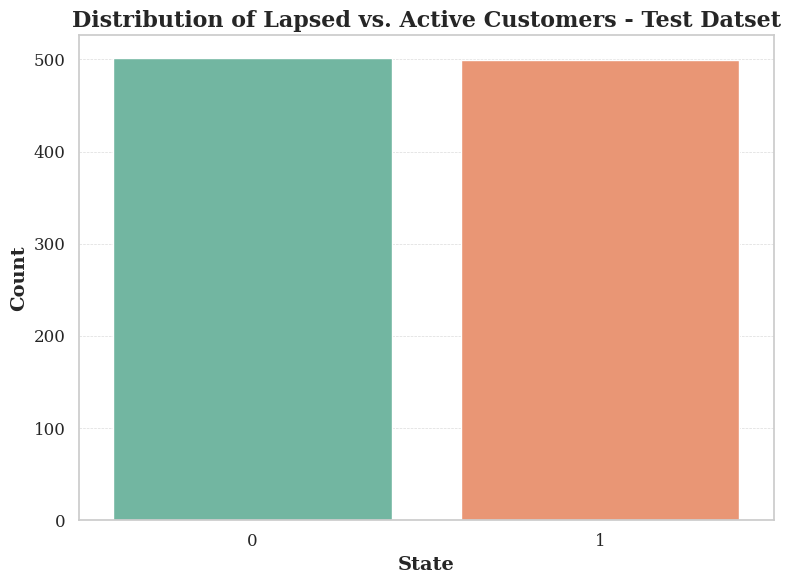

In [12]:
y_test_df = pd.DataFrame(y_test, columns = ['state'])

sns.set(style = "whitegrid", palette = "Set2")

plt.figure(figsize = (8, 6))

ax = sns.countplot(x = 'state', data = y_test_df, palette = "Set2")

plt.title('Distribution of Lapsed vs. Active Customers - Test Datset', fontsize = 16, weight = 'bold', family ='serif')
plt.xlabel('State', fontsize = 14, weight = 'bold', family = 'serif')
plt.ylabel('Count', fontsize = 14, weight = 'bold', family = 'serif')

plt.xticks(fontsize = 12, family = 'serif')
plt.yticks(fontsize = 12, family = 'serif')
plt.grid(axis = 'y', linestyle = '--', linewidth = 0.5, alpha = 0.7)

plt.tight_layout()
plt.savefig('distribution_of_lapsed_vs_active_customers_test.png', bbox_inches = 'tight', dpi = 300)
plt.show()

#### Decision Tree Classifier

The performance of the Decision Tree model with all the variables is the following:

- Accuracy: 0.772
- F1 Score: 0.7625
- Recall: 0.7334669338677354
- ROC AUC Score: 0.7719230876923507

In [13]:
dt = DecisionTreeClassifier(random_state = 42)

dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

print("Decision Tree Classifier Performance:")
print(classification_report(y_test, y_pred_dt))
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("F1 Score:", f1_score(y_test, y_pred_dt))
print("Recall:", recall_score(y_test, y_pred_dt))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_dt))

Decision Tree Classifier Performance:
              precision    recall  f1-score   support

           0       0.75      0.81      0.78       501
           1       0.79      0.73      0.76       499

    accuracy                           0.77      1000
   macro avg       0.77      0.77      0.77      1000
weighted avg       0.77      0.77      0.77      1000

Accuracy: 0.772
F1 Score: 0.7625
Recall: 0.7334669338677354
ROC AUC Score: 0.7719230876923507


At this part, a Decision Tree Classifier model, was trained on the training data and used to calculate SHAP (SHapley Additive exPlanations) values for the test set using a TreeExplainer. The test set's 'years_in_the_program' feature was categorized into three cohorts:
- Less than 1 year 
- 1-5 years
- More than 5 years 

<br/>

The mean absolute SHAP values for each cohort were computed by grouping the SHAP values DataFrame by cohort and calculating the mean absolute SHAP values for each feature. An Explanation object was created for the cohort means using SHAP's Explanation class, which included the mean absolute SHAP values for each feature across different cohorts. A bar plot was generated to visualize the mean absolute SHAP values for each feature, averaged across all cohorts, and saved as an image file (shap_bar_plot.png) to provide insights into the most influential features for predicting customer churn.
<br/>

As shown in the barplot below, the three most important variables for the model are:
- months_since_last_transaction
- sum_collect
- sum_collect_points
<br/>

So, we are going to run the Desicion Tree model again, but only with the above variables. 

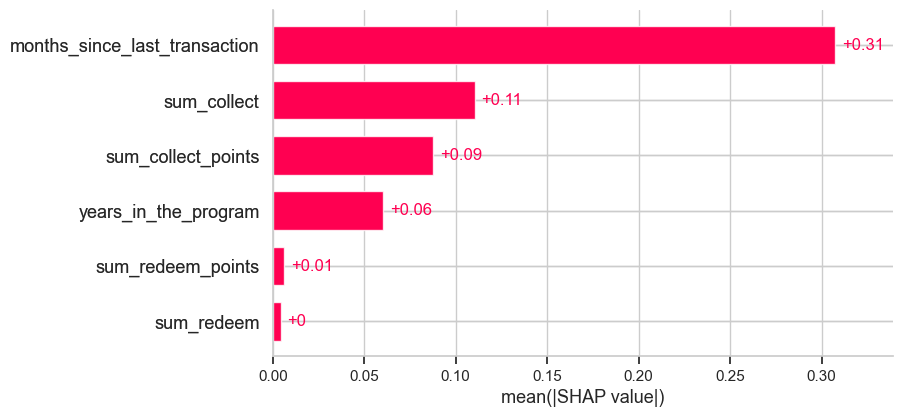

In [14]:
CustomerChurn_TrData = pd.read_csv('CustomerChurnTrainingData.csv')

unique_states = CustomerChurn_TrData['state'].unique()
assert len(unique_states) == 2, "Target variable 'state' should be binary."

X = CustomerChurn_TrData.drop(columns = ['state'])
y = CustomerChurn_TrData['state']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

model = DecisionTreeClassifier(random_state = 42)
model.fit(X_train, y_train)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

def categorize_years(years):
    if years < 1:
        return 'Less than 1 year'
    elif 1 <= years <= 5:
        return '1-5 years'
    else:
        return 'More than 5 years'

cohorts = X_test['years_in_the_program'].apply(categorize_years).values

def mean_abs_shap_per_cohort(shap_values, cohorts):
    df_shap = pd.DataFrame(shap_values, columns = X_test.columns)
    df_shap['cohort'] = cohorts
    cohort_means = df_shap.groupby('cohort').apply(lambda x: x.drop(columns = 'cohort').abs().mean()).reset_index()
    return cohort_means

shap_values_class_1 = shap_values[:, :, 1]
cohort_means = mean_abs_shap_per_cohort(shap_values_class_1, cohorts)

shap_cohort_means = shap.Explanation(values = cohort_means.drop(columns = 'cohort').values,
                                     base_values = np.zeros(cohort_means.shape[1]),
                                     data = cohort_means.drop(columns = 'cohort').values,
                                     feature_names = cohort_means.columns[1:])

shap.plots.bar(shap_cohort_means.abs.mean(axis = 0))

plt.savefig('shap_bar_plot.png')
plt.close()  

The performance of the Decision Tree model with all the variables is the following:

- Accuracy: 0.766
- F1 Score: 0.7645875251509054
- Recall: 0.7615230460921844
- ROC AUC Score: 0.7659910639642559

In [15]:
selected_features = ["months_since_last_transaction", "sum_collect"]

X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]
dt_selected = DecisionTreeClassifier(random_state = 42)
dt_selected.fit(X_train_selected, y_train)

y_pred_dt_selected = dt_selected.predict(X_test_selected)

print("Decision Tree Classifier (selected features) Performance:")
print(classification_report(y_test, y_pred_dt_selected))
print("Accuracy:", accuracy_score(y_test, y_pred_dt_selected))
print("F1 Score:", f1_score(y_test, y_pred_dt_selected))
print("Recall:", recall_score(y_test, y_pred_dt_selected))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_dt_selected))

Decision Tree Classifier (selected features) Performance:
              precision    recall  f1-score   support

           0       0.83      0.81      0.82       501
           1       0.81      0.84      0.83       499

    accuracy                           0.82      1000
   macro avg       0.82      0.82      0.82      1000
weighted avg       0.82      0.82      0.82      1000

Accuracy: 0.824
F1 Score: 0.8260869565217391
Recall: 0.8376753507014028
ROC AUC Score: 0.8240272961091843


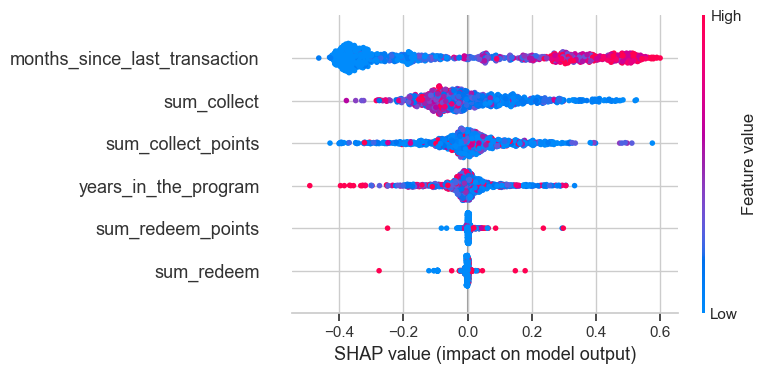

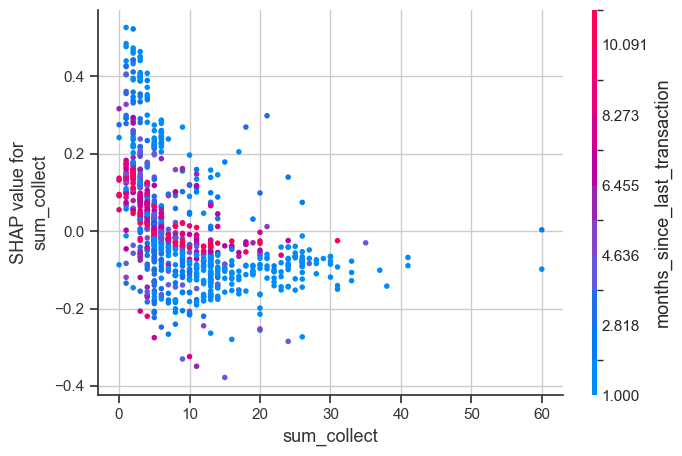

In [16]:
explainer = shap.TreeExplainer(model)
expected_value_class_1 = explainer.expected_value[1]

shap.summary_plot(shap_values_class_1, X_test)

shap.dependence_plot("sum_collect", shap_values_class_1, X_test)
shap.force_plot(expected_value_class_1, shap_values_class_1[0], X_test.iloc[0])

### 3. Prescriptive Analytics

The Logistic Regression and Decision Tree models have been evaluated on the same dataset.
- The predictions from both models are: [0, 1, 1, 0, 0].

<br/>

The Logistic Regression model uses the features: 
- sum_redeem_points
- years_in_the_program
- months_since_last_transaction

While, the Decision Tree model uses the features:
- months_since_last_transaction 
- sum_collect


In [17]:
feature_map = {
    "Logistic Regression": ['sum_redeem_points', 'years_in_the_program', 'months_since_last_transaction'],  # Use the same features as used in training
    "Decision Tree": ['months_since_last_transaction', 'sum_collect']
}

def evaluate_models(models, X_new):
    predictions = {}
    for model_name, model in models.items():
        features = feature_map[model_name]
        X_new_subset = X_new[features]
        y_pred = model.predict(X_new_subset)
        predictions[model_name] = y_pred
    return predictions

X_new = ScoreData_Sink[['sum_collect', 'sum_redeem', 'sum_collect_points', 'sum_redeem_points', 'years_in_the_program', 'months_since_last_transaction']]

models = {
    "Logistic Regression": logreg,
    "Decision Tree": dt_selected  
}

predictions = evaluate_models(models, X_new)

for model_name, y_pred in predictions.items():
    print(f"{model_name} Predictions:", y_pred)

Logistic Regression Predictions: [0 1 1 0 0]
Decision Tree Predictions: [0 1 1 0 0]


## Visualize churn by 
- sum_redeem_points
- months_since_last_transaction

In [18]:
X = CustomerChurn_TrData[['months_since_last_transaction', 'sum_collect']]
y = CustomerChurn_TrData['state']

y_prob = dt_selected.predict_proba(X)[:, 1]

thresholds = np.arange(0.0, 1.0, 0.01)
f1_scores = []

for threshold in thresholds:
    y_pred = (y_prob >= threshold).astype(int)
    f1_scores.append(f1_score(y, y_pred))

f1_scores = np.array(f1_scores)

optimal_threshold_index = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_threshold_index]
print(f"Optimal Threshold: {optimal_threshold}")

Optimal Threshold: 0.38


In [19]:
CustomerChurn_TrData['Predicted_State'] = (y_prob >= optimal_threshold).astype(int)
CustomerChurn_TrData[['state', 'Predicted_State']]

,state,Predicted_State
0,0,0
1,1,1
2,1,1
3,0,0
4,1,1
...,...,...
4995,0,1
4996,1,1
4997,1,1
4998,0,0


In [20]:
churners = CustomerChurn_TrData[CustomerChurn_TrData['Predicted_State'] == 1]
non_churners = CustomerChurn_TrData[CustomerChurn_TrData['Predicted_State'] == 0]

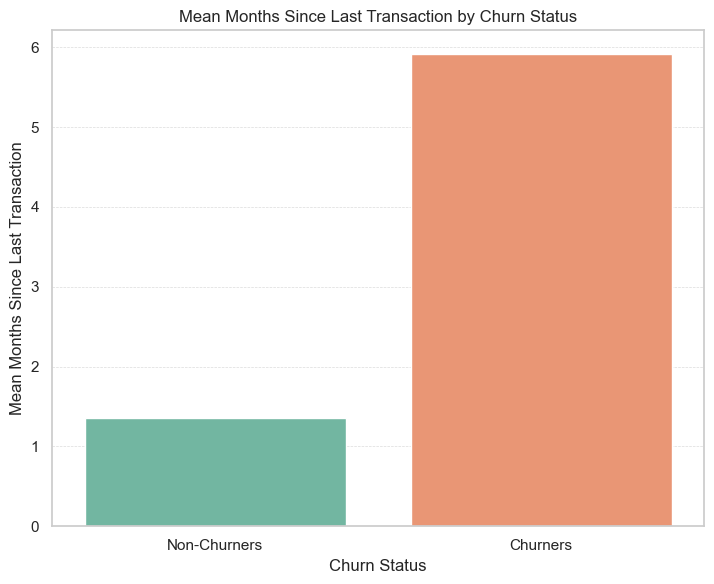

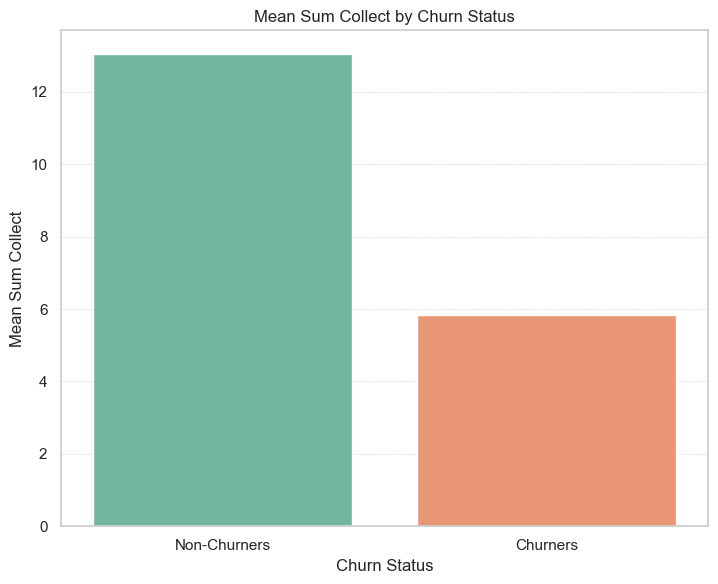

In [21]:
def format_feature_name(name):
    return name.replace('_', ' ').title()

for feature in X:
    plt.figure(figsize = (14, 6))
    
    ax = plt.subplot(1, 2, 1)
    sns.barplot(x = 'Predicted_State', y = feature, data = CustomerChurn_TrData, errorbar = None)
    plt.title(f'Mean {format_feature_name(feature)} by Churn Status')
    plt.xlabel('Churn Status')
    plt.ylabel(f'Mean {format_feature_name(feature)}')
    plt.xticks([0, 1], ['Non-Churners', 'Churners'])
    ax.yaxis.grid(True, linestyle = '--', linewidth = 0.5, alpha = 0.7)

    plt.tight_layout()
    plt.savefig(f'{feature}_plot.png', bbox_inches='tight')
    plt.show()
    plt.close()

## Plots for the Report

In [22]:
plt.figure(figsize=(10, 6))

shap.plots.bar(shap_cohort_means.abs.mean(axis=0), show=False)
plt.yticks(rotation=30)
plt.subplots_adjust(left=0.3, right=0.9, top=0.9, bottom=0.2)  
plt.savefig('shap_bar_plot.png')  
plt.close()  

In [23]:
plt.figure(figsize = (8, 6)) 
shap.summary_plot(shap_values_class_1, X_test, show = False)
plt.savefig('shap_summary_plot.png')  
plt.close() 

In [24]:
plt.figure(figsize = (8, 6))  
shap.dependence_plot("sum_collect", shap_values_class_1, X_test, show = False)
plt.savefig('shap_dependence_plot.png')  
plt.close()  

<Figure size 800x600 with 0 Axes>